# Test with fitto distributions

In [119]:
import numpy as np
import scipy as sp
from lbfgsb import minimize_lbfgsb
from pyrtid.utils import finite_gradient
import numpy.typing as npt

NDArrayFloat = npt.NDArray[np.float64]
NDArrayInt = npt.NDArray[np.int64]
from numpy.typing import ArrayLike
import numdifftools as nd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

multimodal_dist_target = np.concatenate(
    (
        np.random.normal(10, 3, 1000),
        np.random.normal(30, 5, 4000),
        np.random.normal(45, 6, 500),
    ),
    axis=0,
)
multimodal_dist_target = np.concatenate(
    (multimodal_dist_target, multimodal_dist_target[:500], multimodal_dist_target[:250])
)

multimodal_dist_init = np.concatenate(
    (
        np.random.normal(-10, 3, 20),
        np.random.normal(20, 5, 100),
        np.random.normal(60, 6, 15),
    ),
    axis=0,
)
multimodal_dist_init = np.concatenate(
    (multimodal_dist_init, multimodal_dist_init[:50], multimodal_dist_init[:25])
)

n_elt_ratio = multimodal_dist_target.size / multimodal_dist_init.size

dist_range = (
    min(np.min(multimodal_dist_target).item(), np.min(multimodal_dist_init).item()),
    max(np.max(multimodal_dist_target).item(), np.max(multimodal_dist_init).item()),
)

In [120]:
pv, bins_target = np.histogram(multimodal_dist_target, bins=50, range=dist_range)
v = (bins_target[:-1] + bins_target[1:]) / 2

pu, bins_init = np.histogram(multimodal_dist_init, bins=50, range=dist_range)
u = (bins_init[:-1] + bins_init[1:]) / 2

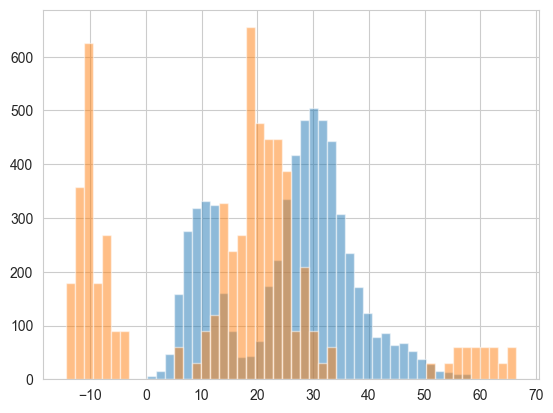

In [121]:
plt.hist(multimodal_dist_target, bins=50, alpha=0.5, range=dist_range)
plt.hist(
    multimodal_dist_init,
    bins=50,
    alpha=0.5,
    weights=np.ones_like(multimodal_dist_init) * n_elt_ratio,
    range=dist_range,
)
plt.show()

In [ ]:
from typing import Tuple, Optional, Union
from scipy.stats._stats_py import _validate_distribution
from scipy.sparse import csc_array, lil_array


def ffill(arr: npt.NDArray) -> npt.NDArray:
    """
    Forward fill (the NAN) in the given array.

    A new array is returned.
    """
    prev = np.arange(np.size(arr))
    prev[np.isnan(arr)] = 0
    prev = np.maximum.accumulate(prev)
    return arr[prev]


def make_dist_values_unique(
    dist: ArrayLike, weights: Optional[ArrayLike] = None
) -> Tuple[ArrayLike, Union[NDArrayFloat, NDArrayInt], NDArrayInt, NDArrayInt]:
    """
    Make the values in the given distribution unique.

    Weights are summed.

    Parameters
    ----------
    dist : ArrayLike
        Values of the (empirical) distribution.
    weights : Optional[ArrayLike], optional
        _description_, by default None

    Returns
    -------
    Tuple[ArrayLike, Union[NDArrayFloat, NDArrayInt], NDArrayInt, NDArrayInt]
        Arrays containing:
        - The unique values by increasing order.
        - The associated (aggregated) weights. If no weights were provided, it is
        simply the count for each unique value.
        - The indices of first occurrence in the original array.
        - The sorter (indices) by increasing order in the original array (`dist`).
    """
    sorter = np.argsort(dist)
    vals, _indices, _counts = np.unique(
        np.asarray(dist)[sorter], return_counts=True, return_index=True
    )

    if weights is None:
        _weights = _counts
    else:
        idx = np.zeros_like(dist)
        idx[:] = np.nan
        idx[_indices] = np.arange(np.size(vals))
        idx = np.asarray(ffill(idx)[np.argsort(sorter)], dtype=np.int64)
        _weights = np.bincount(idx, weights)
    return vals, _weights, _indices, sorter


def get_cdfs(
    u_values: ArrayLike,
    v_values: ArrayLike,
    u_weights: Optional[ArrayLike] = None,
    v_weights: Optional[ArrayLike] = None,
) -> Tuple[NDArrayFloat, NDArrayFloat, NDArrayFloat, NDArrayInt]:
    """Return the merged cumulative density functions and associated weights."""
    u_values, u_weights = _validate_distribution(u_values, u_weights)
    v_values, v_weights = _validate_distribution(v_values, v_weights)

    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    all_values = np.concatenate((u_values, v_values))
    all_sorter = np.argsort(all_values, kind="mergesort")
    all_values = all_values[all_sorter]

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1], "right")
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1], "right")

    # Calculate the CDFs of u and v using their weights, if specified.
    if u_weights is None:
        u_cdf = u_cdf_indices / u_values.size
    else:
        u_sorted_cumweights = np.concatenate(([0], np.cumsum(u_weights[u_sorter])))
        u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    if v_weights is None:
        v_cdf = v_cdf_indices / v_values.size
    else:
        v_sorted_cumweights = np.concatenate(([0], np.cumsum(v_weights[v_sorter])))
        v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]

    return u_cdf, v_cdf, deltas, all_sorter


def cdf_distance(
    p: float,
    u_values: ArrayLike,
    v_values: ArrayLike,
    u_weights: Optional[ArrayLike] = None,
    v_weights: Optional[ArrayLike] = None,
) -> float:
    r"""
    Compute, between two one-dimensional distributions :math:`u` and
    :math:`v`, whose respective CDFs are :math:`U` and :math:`V`, the
    statistical distance that is defined as:

    .. math::

        l_p(u, v) = \left( \int_{-\infty}^{+\infty} |U-V|^p \right)^{1/p}

    p is a positive parameter; p = 1 gives the Wasserstein distance, p = 2
    gives the energy distance.

    Parameters
    ----------
    u_values, v_values : array_like
        Values observed in the (empirical) distribution.
    u_weights, v_weights : array_like, optional
        Weight for each value. If unspecified, each value is assigned the same
        weight.
        `u_weights` (resp. `v_weights`) must have the same length as
        `u_values` (resp. `v_values`). If the weight sum differs from 1, it
        must still be positive and finite so that the weights can be normalized
        to sum to 1.

    Returns
    -------
    distance : float
        The computed distance between the distributions.

    Notes
    -----
    The input distributions can be empirical, therefore coming from samples
    whose values are effectively inputs of the function, or they can be seen as
    generalized functions, in which case they are weighted sums of Dirac delta
    functions located at the specified values.

    References
    ----------
    .. [1] Bellemare, Danihelka, Dabney, Mohamed, Lakshminarayanan, Hoyer,
           Munos "The Cramer Distance as a Solution to Biased Wasserstein
           Gradients" (2017). :arXiv:`1705.10743`.

    """
    # First make values in the distribution unique to reduce the complexity
    # of the algorithm
    new_u, new_u_weights = make_dist_values_unique(u_values, u_weights)[:2]
    new_v, new_v_weights = make_dist_values_unique(v_values, v_weights)[:2]

    u_cdf, v_cdf, deltas, _ = get_cdfs(new_u, new_v, new_u_weights, new_v_weights)

    # Compute the value of the integral based on the CDFs.
    # If p = 1 or p = 2, we avoid using np.power, which introduces an overhead
    # of about 15%.
    if p == 1:
        return np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))
    if p == 2:
        return np.sqrt(np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))
    return np.power(
        np.sum(np.multiply(np.power(np.abs(u_cdf - v_cdf), p), deltas)), 1 / p
    )


def cdf_distance_gradient(
    p: float,
    u_values: ArrayLike,
    v_values: ArrayLike,
    u_weights: Optional[ArrayLike] = None,
    v_weights: Optional[ArrayLike] = None,
) -> NDArrayFloat:
    r"""
    Compute, between two one-dimensional distributions :math:`u` and
    :math:`v`, whose respective CDFs are :math:`U` and :math:`V`, the
    gradient with respect to :math:`u` of the statistical distance that is defined as:

    .. math::

        l_p(u, v) = \left( \int_{-\infty}^{+\infty} |U-V|^p \right)^{1/p}

    p is a positive parameter; p = 1 gives the Wasserstein distance, p = 2
    gives the energy distance.

    Parameters
    ----------
    u_values, v_values : array_like
        Values observed in the (empirical) distribution.
    u_weights, v_weights : array_like, optional
        Weight for each value. If unspecified, each value is assigned the same
        weight.
        `u_weights` (resp. `v_weights`) must have the same length as
        `u_values` (resp. `v_values`). If the weight sum differs from 1, it
        must still be positive and finite so that the weights can be normalized
        to sum to 1.

    Returns
    -------
    distance gradient : NDArrayFloat
        The computed distance between the distributions.

    Notes
    -----
    The input distributions can be empirical, therefore coming from samples
    whose values are effectively inputs of the function, or they can be seen as
    generalized functions, in which case they are weighted sums of Dirac delta
    functions located at the specified values.

    References
    ----------
    .. [1] Bellemare, Danihelka, Dabney, Mohamed, Lakshminarayanan, Hoyer,
           Munos "The Cramer Distance as a Solution to Biased Wasserstein
           Gradients" (2017). :arXiv:`1705.10743`.

    """

    # First make values in the distribution unique to reduce the complexity
    # And allow the derivation with respect to repeated values (in u)
    new_u, new_u_weights, old_u_indices, u_sorter = make_dist_values_unique(
        u_values, u_weights
    )
    new_v_values, new_v_weights, _, _ = make_dist_values_unique(v_values, v_weights)

    u_cdf, v_cdf, deltas, all_sorter = get_cdfs(
        new_u, new_v_values, new_u_weights, new_v_weights
    )

    # Note about the derivation => the derivative of u_cdf with respect to u_values
    # is always null (the order is preserved)
    # So the only term that matters in the derivation is the one with resepct to deltas
    if p == 1:
        _temp: NDArrayFloat = np.abs(u_cdf - v_cdf)
    elif p == 2:
        _temp = (
            0.5
            / np.sqrt(np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))
            * np.square(u_cdf - v_cdf)
        )
    else:
        _temp = (
            1
            / p
            * np.power(
                np.sum(np.multiply(np.power(np.abs(u_cdf - v_cdf), p), deltas)),
                1 / p - 1,
            )
            * np.power(np.abs(u_cdf - v_cdf), p)
        )

    # First approach = more expensive because one needs to build J,
    # the derivatives of deltas with respect to the sorted u_values
    # it is a sparse matrix filled by 1 and -1
    # n = u_cdf_indices.size
    # J = sp.sparse.diags_array([-np.ones(n + 1), np.ones(n)], offsets=[0, 1]).tocsc()[
    #     :-1, np.argsort(all_sorter)
    # ][:, :np.size(u_values)]
    # conversion to csc for faster multiplication
    # return J.tocsc().T @ _temp

    # Second approach strictly equivalent but faster
    grad = (
        -np.concatenate([_temp, [0.0]], dtype=np.float64)[np.argsort(all_sorter)][
            : np.size(new_u)
        ]
        + np.concatenate([[0.0], _temp], dtype=np.float64)[np.argsort(all_sorter)][
            : np.size(new_u)
        ]
    )

    # This is to hanbdle duplictaed values
    out = np.zeros_like(u_values)
    out[:] = np.nan
    out[old_u_indices] = grad / new_u_weights
    out = ffill(out)[np.argsort(u_sorter)]
    if u_weights is not None:
        return out * np.array(u_weights, dtype=np.float64)
    else:
        return out


def cost_fun_p1(x) -> float:
    return cdf_distance(1, x, v, None, pv) * 1e3


def cost_fun_grad_p1(x) -> NDArrayFloat:
    return cdf_distance_gradient(1, x, v, None, pv) * 1e3


def cost_fun_p2(x) -> float:
    return cdf_distance(2, x, v, None, pv) * 1e3


def cost_fun_grad_p2(x) -> NDArrayFloat:
    return cdf_distance_gradient(2, x, v, None, pv) * 1e3


def cost_fun_p3(x) -> float:
    return cdf_distance(3, x, v, None, pv) * 1e5


def cost_fun_grad_p3(x) -> NDArrayFloat:
    return cdf_distance_gradient(3, x, v, None, pv) * 1e5

In [ ]:
test_dist = np.array([1.0, 3.0, 3.0, 3.0, 3.0, 1.0, 1.0, 4.0])
test_weights = np.array([1.5, 3.0, 3.0, 3.0, 3.0, 1.5, 1.5, 4.0])
make_dist_values_unique(test_dist, test_weights)

(array([1., 3., 4.]),
 array([ 4.5, 12. ,  4. ]),
 array([0, 3, 7]),
 array([0, 5, 6, 1, 2, 3, 4, 7]))

In [124]:
cdf_distance(1, u, u, pu, pu)

0.0

In [125]:
cdf_distance(1, u, v, pu, pv)

12.94211548462711

In [126]:
cdf_distance(1, multimodal_dist_init, multimodal_dist_target, None, None)

12.934831708541005

In [127]:
cdf_distance(1, multimodal_dist_init, v, None, pv)

12.943960227074523

In [128]:
cost_fun_p1(multimodal_dist_init)

12943.960227074524

In [129]:
grad_an_p1 = cost_fun_grad_p1(multimodal_dist_init)

In [130]:
res_p1 = minimize_lbfgsb(
    x0=multimodal_dist_init, fun=cost_fun_p1, jac=cost_fun_grad_p1, maxiter=20
)

In [131]:
res_p1

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: True
   status: 1
      fun: 155.70528228307822
        x: [ 9.079e+00  1.229e+01 ...  3.175e+01  2.847e+01]
      nit: 20
      jac: [ 4.762e+00  4.762e+00 ...  4.762e+00  4.762e+00]
     nfev: 38
     njev: 38
 hess_inv: <210x210 LbfgsInvHessProduct with dtype=float64>

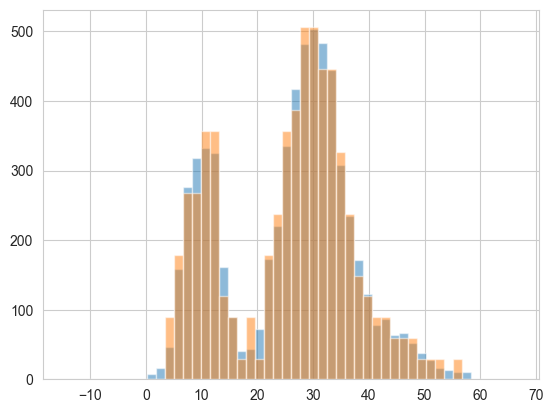

In [132]:
plt.hist(multimodal_dist_target, bins=50, alpha=0.5, range=dist_range)
plt.hist(
    res_p1.x,
    bins=50,
    alpha=0.5,
    range=dist_range,
    weights=np.ones_like(res_p1.x) * n_elt_ratio,
)
plt.show()

In [133]:
grad_fd_p1 = nd.Gradient(cost_fun_p1, step=1e-2)(multimodal_dist_init)

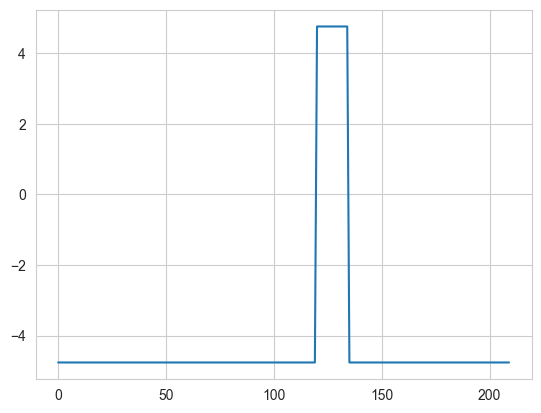

In [134]:
plt.plot(grad_an_p1)

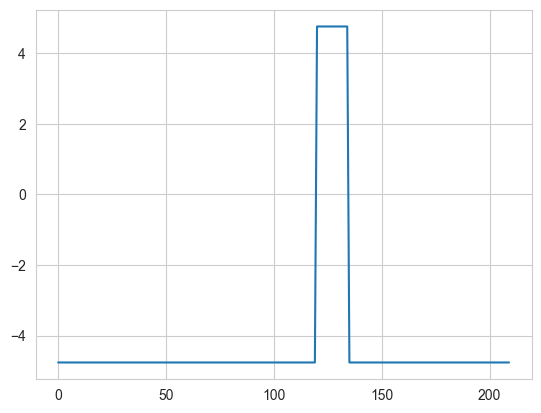

In [135]:
plt.plot(grad_fd_p1)

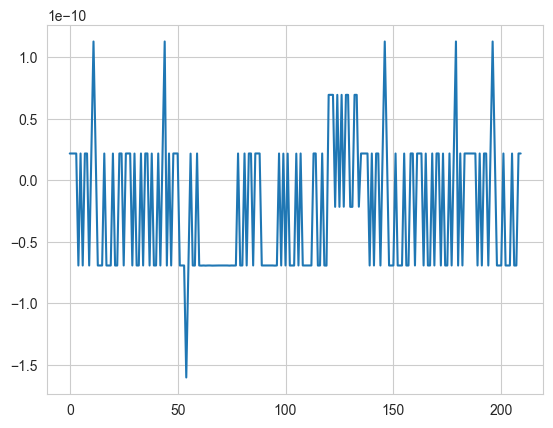

In [136]:
plt.plot(grad_an_p1 - grad_fd_p1)

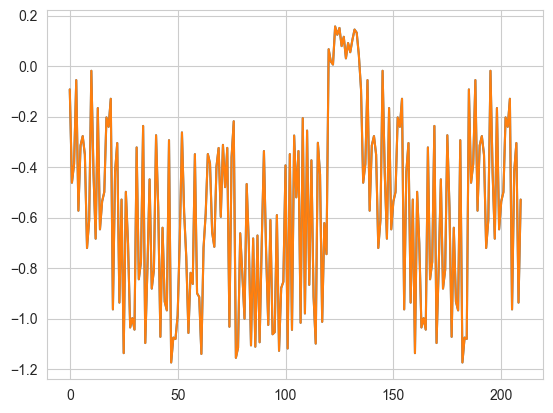

In [137]:
grad_fd_p2 = nd.Gradient(cost_fun_p2, step=1e-5)(multimodal_dist_init)
grad_an_p2 = cost_fun_grad_p2(multimodal_dist_init)
plt.plot(grad_fd_p2)
plt.plot(grad_an_p2)

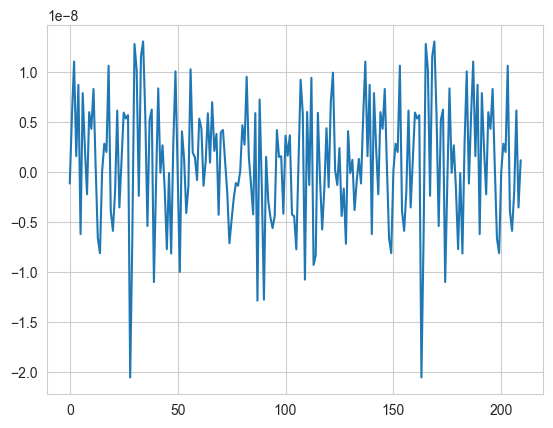

In [138]:
plt.plot(grad_fd_p2 - grad_an_p2)

In [139]:
res_p2 = minimize_lbfgsb(
    x0=multimodal_dist_init, fun=cost_fun_p2, jac=cost_fun_grad_p2, maxiter=20
)

In [140]:
res_p2

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: True
   status: 1
      fun: 121.01161905742724
        x: [ 5.234e+00  2.157e+01 ...  1.216e+01  3.180e+01]
      nit: 20
      jac: [-9.584e-01 -5.740e-01 ... -8.729e-01  1.087e+00]
     nfev: 33
     njev: 33
 hess_inv: <210x210 LbfgsInvHessProduct with dtype=float64>

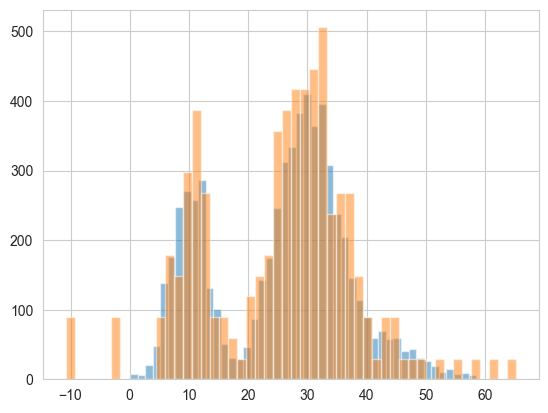

In [141]:
plt.hist(multimodal_dist_target, bins=50, alpha=0.5)
plt.hist(res_p2.x, bins=50, alpha=0.5, weights=np.ones_like(res_p1.x) * n_elt_ratio)
plt.show()

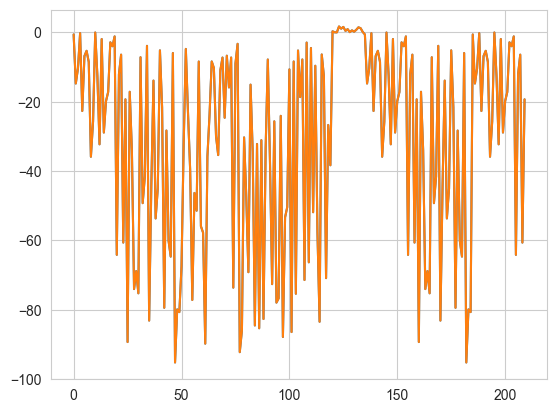

In [142]:
grad_fd_p3 = nd.Gradient(cost_fun_p3)(multimodal_dist_init)
grad_an_p3 = cost_fun_grad_p3(multimodal_dist_init)
plt.plot(grad_fd_p3)
plt.plot(grad_an_p3)

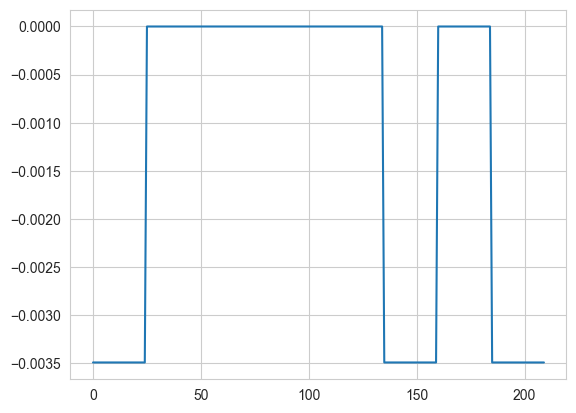

In [143]:
plt.plot(grad_fd_p3 - grad_an_p3)

In [144]:
res_p3 = minimize_lbfgsb(
    x0=multimodal_dist_init, fun=cost_fun_p3, jac=cost_fun_grad_p3, maxiter=20
)

In [145]:
res_p3

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: True
   status: 1
      fun: 8300.839422912253
        x: [ 5.886e+00  2.452e+01 ...  2.989e+01  2.818e+01]
      nit: 20
      jac: [-1.322e+01 -2.134e+00 ... -6.357e+01 -6.752e+01]
     nfev: 29
     njev: 29
 hess_inv: <210x210 LbfgsInvHessProduct with dtype=float64>

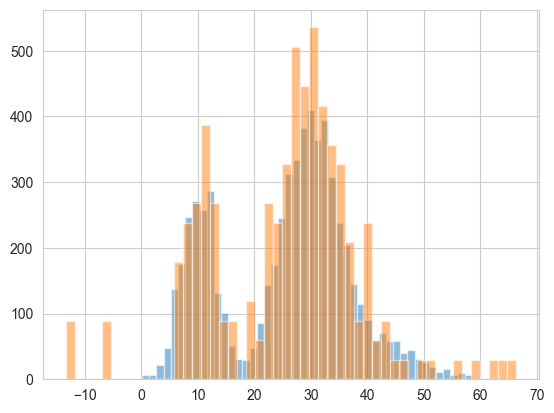

In [146]:
plt.hist(multimodal_dist_target, bins=50, alpha=0.5)
plt.hist(res_p3.x, bins=50, alpha=0.5, weights=np.ones_like(res_p3.x) * n_elt_ratio)
plt.show()

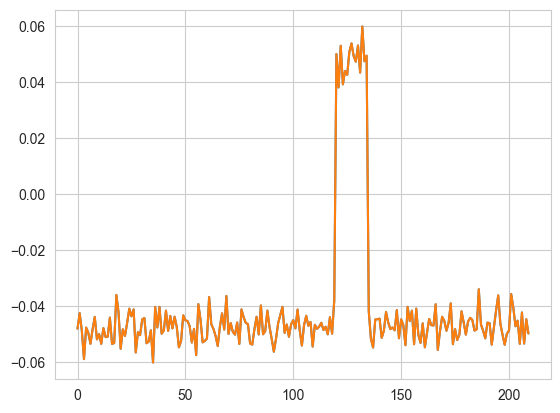

In [147]:
weights = np.abs(np.random.normal(loc=10, size=multimodal_dist_init.size))

# def cost_fun(x) -> float:
#     return cdf_distance(p, x, v, weights, pv) * 1e1


# def cost_fun_grad(x) -> NDArrayFloat:
#     return cdf_distance_gradient(p, x, v, weights, pv) * 1e1

# assert is_gradient_correct(multimodal_dist_init, fm=cost_fun, grad=cost_fun_grad, eps=1e-3)


def cost_fun(x) -> float:
    return cdf_distance(1, x, v, weights, pv) * 10.0


def cost_fun_grad(x) -> NDArrayFloat:
    return cdf_distance_gradient(1, x, v, weights, pv) * 10.0


grad_fd = nd.Gradient(cost_fun, step=1e-4)(multimodal_dist_init)
grad_an = cost_fun_grad(multimodal_dist_init)

plt.plot(grad_fd)
plt.plot(grad_an)